# Example 4b: Fermionic single impurity model

## Example of the Fermionic HEOM solver

Here we model a single fermion coupled to two electronic leads or reservoirs (e.g.,  this can describe a single quantum dot, a molecular transistor, etc).  Note that in this implementation we primarily follow the definitions used by Christian Schinabeck in his Dissertation https://opus4.kobv.de/opus4-fau/files/10984/DissertationChristianSchinabeck.pdf and related publications.


Notation:  
$K=L/R$ refers to  left or right leads.

$\sigma=\pm$ refers to input/output


We choose a Lorentzian spectral density for the leads, with a peak at the chemical potential. The latter simplifies a little the notation required for the correlation functions, but can be relaxed if neccessary.

$$J(\omega) = \frac{\Gamma  W^2}{((\omega-\mu_K)^2 +W^2 )}$$


Fermi distribution is

$$f_F (x) = (\exp(x) + 1)^{-1}$$

gives correlation functions

$$C^{\sigma}_K(t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} d\omega e^{\sigma i \omega t} \Gamma_K(\omega) f_F[\sigma\beta(\omega - \mu)]$$


As with the Bosonic case we can treat these with Matsubara, Pade, or fitting approaches.

The Pade decomposition approximates the Fermi distubition as 

$$f_F(x) \approx f_F^{\mathrm{approx}}(x) = \frac{1}{2} - \sum_l^{l_{max}} \frac{2k_l x}{x^2 + \epsilon_l^2}$$

$k_l$ and $\epsilon_l$ are co-efficients defined in J. Chem Phys 133,10106

Evaluating the integral for the correlation functions gives,


$$C_K^{\sigma}(t) \approx \sum_{l=0}^{l_{max}} \eta_K^{\sigma_l} e^{-\gamma_{K,\sigma,l}t}$$

where

$$\eta_{K,0} = \frac{\Gamma_KW_K}{2} f_F^{approx}(i\beta_K W)$$

$$\gamma_{K,\sigma,0} = W_K - \sigma i\mu_K$$ 

$$\eta_{K,l\neq 0} = -i\cdot \frac{k_m}{\beta_K} \cdot \frac{\Gamma_K W_K^2}{-\frac{\epsilon^2_m}{\beta_K^2} + W_K^2}$$

$$\gamma_{K,\sigma,l\neq 0}= \frac{\epsilon_m}{\beta_K} - \sigma i \mu_K$$  




In [1]:
from qutip import *
%pylab inline

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
Populating the interactive namespace from numpy and matplotlib


/home/neill/anaconda3/envs/bofin_env/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['shape', 'identity', 'info', 'squeeze']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

from bofin.heom import FermionicHEOMSolver
import time
from scipy.integrate import quad


In [4]:
def deltafun(j,k):
    if j==k: 
        return 1.
    else:
        return 0.

In [5]:

from qutip.states import enr_state_dictionaries

def get_aux_matrices(full, level, N_baths, Nk, N_cut, shape, dims):
    """
    Extracts the auxiliary matrices at a particular level
    from the full hierarchy ADOs.
    
    Parameters
    ----------
    full: ndarray
        A 2D array of the time evolution of the ADOs.
    
    level: int
        The level of the hierarchy to get the ADOs.
        
    N_cut: int
        The hierarchy cutoff.
    
    k: int
        The total number of exponentials used in each bath (assumed equal).
    
    N_baths: int
        The number of baths.
        
    shape : int
        the size of the ''system'' hilbert space
        
    dims : list
        the dimensions of the system hilbert space
    """
    #Note: Max N_cut is Nk*N_baths
    nstates, state2idx, idx2state = enr_state_dictionaries([2]*(Nk*N_baths) ,N_cut)#_heom_state_dictionaries([Nc + 1]*(Nk), Nc)
    aux_indices = []
    
    aux_heom_indices = []
    for stateid in state2idx:
        if np.sum(stateid) == level:
            aux_indices.append(state2idx[stateid])
            aux_heom_indices.append(stateid)
    full = np.array(full)
    aux = []

    for i in aux_indices:
        qlist = [Qobj(full[k, i, :].reshape(shape, shape).T,dims=dims) for k in range(len(full))]
        aux.append(qlist)
    return aux, aux_heom_indices, idx2state

In [6]:
#Define parameters and plot lead spectra

Gamma = 0.01  #coupling strength
W=1. #cut-off
T = 0.025851991 #temperature
beta = 1./T

theta = 2. #Bias
mu_l = theta/2.
mu_r = -theta/2.

w_list = np.linspace(-2,2,100)

def Gamma_L_w(w):
    return Gamma*W**2/((w-mu_l)**2 + W**2)

def Gamma_R_w(w):
    return Gamma*W**2/((w-mu_r)**2 + W**2)


def f(x):
    kB=1.
    return 1/(exp(x)+1.)
def f2(x):
    return 0.5


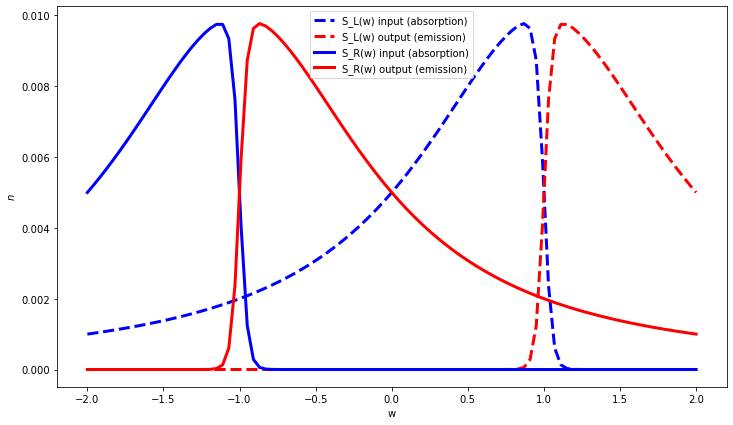

In [7]:

fig, ax1 = plt.subplots(figsize=(12, 7))
gam_list_in = [Gamma_L_w(w)*f(beta*(w-mu_l)) for w in w_list]

ax1.plot(w_list,gam_list_in, "b--", linewidth=3, label= r"S_L(w) input (absorption)")


ax1.set_xlabel("w")
ax1.set_ylabel(r"$S(\omega)$")
ax1.legend()


gam_list_out = [Gamma_L_w(w)*f(-beta*(w-mu_l)) for w in w_list]
spec = [Gamma_L_w(w) for w in w_list]

ax1.plot(w_list,gam_list_out, "r--", linewidth=3, label= r"S_L(w) output (emission)")


gam_list_in = [Gamma_R_w(w)*f(beta*(w-mu_r)) for w in w_list]

ax1.plot(w_list,gam_list_in, "b", linewidth=3, label= r"S_R(w) input (absorption)")




gam_list_out = [Gamma_R_w(w)*f(-beta*(w-mu_r)) for w in w_list]
spec = [Gamma_R_w(w) for w in w_list]

ax1.plot(w_list,gam_list_out, "r", linewidth=3, label= r"S_R(w) output (emission)")
ax1.set_xlabel("w")
ax1.set_ylabel(r"$n$")
ax1.legend()

[0, 0.9999999999999862, 0.9999999999999868, 1.0000000000012206, 1.0000001690305604, 1.0003807129102773, 1.0439710525567194, 1.5305316265017264, 3.2018172059815946, 9.279187642797012, 84.94411159022091]
[0, 3.141592653589793, 9.424777960769381, 15.707963267949479, 21.991148682663308, 28.274698131942646, 34.62641555503289, 42.3031405780699, 56.25248560357533, 90.71566976800949, 267.89788247787743]


<ipython-input-8-ffb7ea0c49f6>:71: RuntimeWarning: overflow encountered in exp
  return 1/(exp(x)+1.)


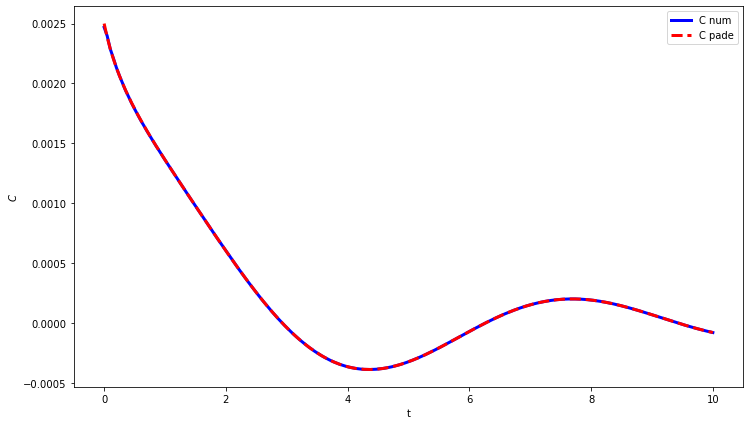

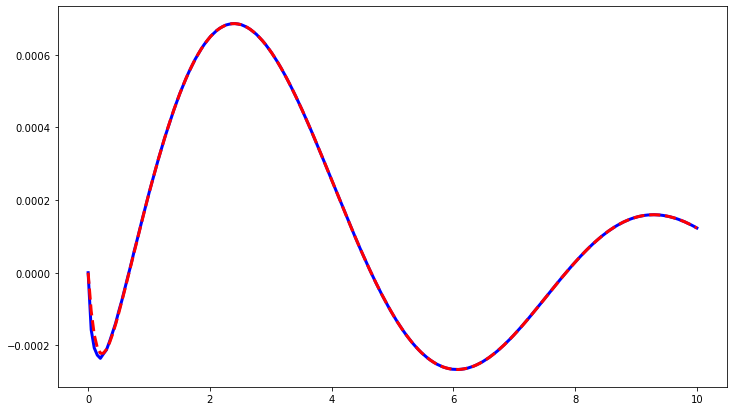

In [8]:
#Pade decompositon: construct correlation parameters

tlist = np.linspace(0,10,200)


#Pade cut-off
lmax =10


w_list = np.linspace(-2,2,100)

def Gamma_L_w(w):
    return Gamma*W**2/((w-mu_l)**2 + W**2)

def Gamma_w(w, mu):
    return Gamma*W**2/((w-mu)**2 + W**2)


def f(x):
    kB=1.
    return 1/(exp(x)+1.)


Alpha =np.zeros((2*lmax,2*lmax))
for j in range(2*lmax):
    for k in range(2*lmax):
        Alpha[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)-1)*(2*(k+1)-1))
        
eigvalsA=eigvalsh(Alpha)  

eps = []
for val in  eigvalsA[0:lmax]:
    #print(-2/val)
    eps.append(-2/val)
    
AlphaP =np.zeros((2*lmax-1,2*lmax-1))
for j in range(2*lmax-1):
    for k in range(2*lmax-1):
        AlphaP[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)+1)*(2*(k+1)+1))
        #AlphaP[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+2)-1)*(2*(k+2)-1))
        
eigvalsAP=eigvalsh(AlphaP)    

chi = []
for val in  eigvalsAP[0:lmax-1]:
    #print(-2/val)
    chi.append(-2/val)

    
eta_list = [0.5*lmax*(2*(lmax + 1) - 1)*( 
  np.prod([chi[k]**2 - eps[j]**2 for k in range(lmax - 1)])/
    np.prod([eps[k]**2 - eps[j]**2 +deltafun(j,k) for k in range(lmax)])) 
          for j in range(lmax)]



kappa = [0]+eta_list
print(kappa)
epsilon = [0]+eps
print(epsilon)


def f_approx(x):
    f = 0.5
    for l in range(1,lmax+1):
        f= f - 2*kappa[l]*x/(x**2+epsilon[l]**2)
    return f

def f(x):
    kB=1.
    return 1/(exp(x)+1.)


def C(tlist,sigma,mu):
    eta_list = []
    gamma_list  =[]
    

    eta_0 = 0.5*Gamma*W*f_approx(1.0j*beta*W)

    gamma_0 = W - sigma*1.0j*mu
    eta_list.append(eta_0)
    gamma_list.append(gamma_0)
    if lmax>0:
        for l in range(1,lmax+1):
            eta_list.append(-1.0j*(kappa[l]/beta)*Gamma*W**2/(-(epsilon[l]**2/beta**2)+W**2))
            gamma_list.append(epsilon[l]/beta - sigma*1.0j*mu)
    c_tot = []
    for t in tlist:
        c_tot.append(sum([eta_list[l]*exp(-gamma_list[l]*t) for l in range(lmax+1)]))
    return c_tot, eta_list, gamma_list
 

def c_t_L_num(t,sigma,mu):
    
    integrand = lambda w: (1/(2*pi))*exp(sigma*1.0j*w*t)*Gamma_w(w,mu)*f(sigma*beta*(w-mu))
    def real_func(x):
        return real(integrand(x))
    def imag_func(x):
        return imag(integrand(x))
    #return quad(integrand,-np.inf,np.inf)[0]
    # This bounds must be increased if W is increased
    # But this integration is quite unstable for large frequencies.
    
    a= -50
    b= 50
    real_integral = quad(real_func, a, b)
    imag_integral = quad(imag_func, a, b)
    return real_integral[0] + 1.0j * imag_integral[0]
    



cppL,etapL,gampL = C(tlist,1.0,mu_l)

cpmL,etamL,gammL = C(tlist,-1.0,mu_l)



cppR,etapR,gampR = C(tlist,1.0,mu_r)

cpmR,etamR,gammR = C(tlist,-1.0,mu_r)


c_num =[c_t_L_num(t,-1.0,mu_r) for t in tlist]


fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.plot(tlist,real(c_num), color="b", linewidth=3, label= r"C num")
ax1.plot(tlist,real(cpmR), "r--", linewidth=3, label= r"C pade")
pos = 1



ax1.set_xlabel("t")
ax1.set_ylabel(r"$C$")
ax1.legend()
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.plot(tlist,imag(c_num), color="b", linewidth=3, label= r"C num")
ax1.plot(tlist,imag(cpmR), "r--", linewidth=3, label= r"C pade")
pos = 0


In [9]:
#heom simulation with above params (Pade)
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

#Single fermion.
d1 = destroy(2)

#Site energy
e1 = 1. 


H0 = e1*d1.dag()*d1 

#There are two leads, but we seperate the interaction into two terms, labelled with \sigma=\pm
#such that there are 4 interaction operators (See paper)
Qops = [d1.dag(),d1,d1.dag(),d1]



Kk=lmax+1
Ncc = 2  #For a single impurity we converge with Ncc = 2


#Note here that the functionality differs from the bosonic case. Here we send lists of lists, were each sub-list
#refers to one of the two coupling terms for each bath (the notation here refers to eta|sigma|L/R)


start = time.time()


eta_list = [etapR,etamR,etapL,etamL]
gamma_list = [gampR,gammR,gampL,gammL]
Qops = [d1.dag(),d1,d1.dag(),d1]

resultHEOM2 = FermionicHEOMSolver(H0, Qops,  eta_list, gamma_list, Ncc,options=options)
end = time.time()
print("run time", end - start)



run time 2.476959705352783


In [10]:
rho_0 = basis(2,0)*basis(2,0).dag()


start = time.time()

rhossHP2,fullssP2=resultHEOM2.steady_state()
end = time.time()
print(end - start)



0.08814382553100586


In [11]:
rho_0 = basis(2,0)*basis(2,0).dag()
tlist = np.linspace(0,100,1000)
out1P2=resultHEOM2.run(rho_0,tlist)

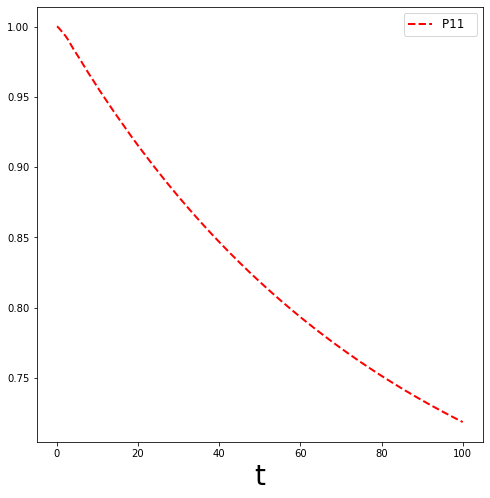

In [12]:
# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))

axes.plot(tlist, expect(out1P2.states,rho_0), 'r--', linewidth=2, label="P11  ")
axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)

<ipython-input-8-ffb7ea0c49f6>:71: RuntimeWarning: overflow encountered in exp
  return 1/(exp(x)+1.)


Text(0, 0.5, '$Im[C]$')

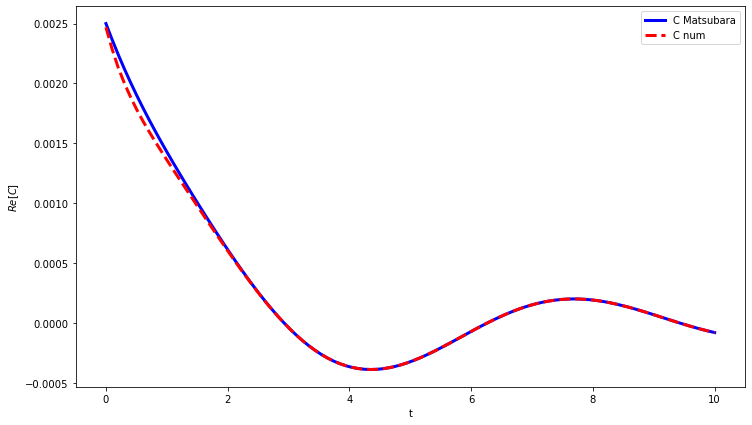

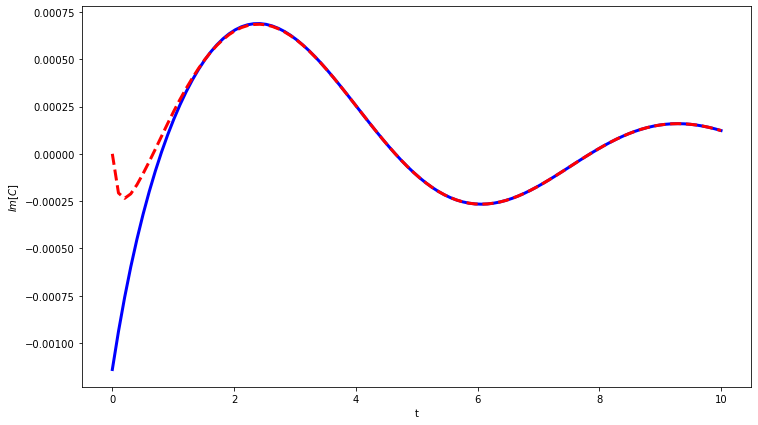

In [13]:
#We can perform the same calculation using Matsubara decomposition
tlist = np.linspace(0,10,100)



lmax = 10
kappa = [0.]
kappa.extend([1. for l in range(1,lmax+1)])
epsilon = [0]
epsilon.extend([(2*l-1)*pi for l in range(1,lmax+1)])

def f_approx(x):
    f = 0.5
    for l in range(1,lmax+1):
        f= f - 2*kappa[l]*x/(x**2+epsilon[l]**2)
    return f

def C(tlist,sigma,mu):
    eta_list = []
    gamma_list  =[]
    
    #l = 0
    eta_0 = 0.5*Gamma*W*f(1.0j*beta*W)
    gamma_0 = W - sigma*1.0j*mu
    eta_list.append(eta_0)
    gamma_list.append(gamma_0)
    if lmax>0:
        for l in range(1,lmax+1):
            eta_list.append(-1.0j*(kappa[l]/beta)*Gamma*W**2/(-(epsilon[l]**2/beta**2)+W**2))
            gamma_list.append(epsilon[l]/beta - sigma*1.0j*mu)
    c_tot = []
    for t in tlist:
        c_tot.append(sum([eta_list[l]*exp(-gamma_list[l]*t) for l in range(lmax+1)]))
    return c_tot, eta_list, gamma_list

def c_t_L_num(t,sigma,mu):
    
    integrand = lambda w: (1/(2*pi))*exp(sigma*1.0j*w*t)*Gamma_w(w,mu)*f(sigma*beta*(w-mu))
    def real_func(x):
        return real(integrand(x))
    def imag_func(x):
        return imag(integrand(x))


    a = -50
    b = 50
    real_integral = quad(real_func, a, b)
    imag_integral = quad(imag_func, a, b)
    return real_integral[0] + 1.0j * imag_integral[0] 
 

cppL,etapL,gampL = C(tlist,1.0,mu_l)

cpmL,etamL,gammL = C(tlist,-1.0,mu_l)


cppR,etapR,gampR = C(tlist,1.0,mu_r)

cpmR,etamR,gammR = C(tlist,-1.0,mu_r)


c_num =[c_t_L_num(t,1.0,mu_l) for t in tlist]


fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.plot(tlist,real(cppL), color="b", linewidth=3, label= r"C Matsubara")
ax1.plot(tlist,real(c_num), "r--", linewidth=3, label= r"C num")


ax1.set_xlabel("t")
ax1.set_ylabel(r"$Re[C]$")
ax1.legend()
fig, ax1 = plt.subplots(figsize=(12, 7))
#print(gam_list)
ax1.plot(tlist,imag(cppL), color="b", linewidth=3, label= r"C Matsubara")
ax1.plot(tlist,imag(c_num), "r--", linewidth=3, label= r"C num")
ax1.set_xlabel("t")
ax1.set_ylabel(r"$Im[C]$")


In [14]:
#heom simu on above params (Matsubara)


d1 = destroy(2)

e1 = 1.


H0 = e1*d1.dag()*d1 


Qops = [d1.dag(),d1,d1.dag(),d1]


rho_0 = basis(2,0)*basis(2,0).dag()

Kk=lmax+1
Ncc = 2

tlist = np.linspace(0,100,1000)


eta_list = [etapR,etamR,etapL,etamL]


gamma_list = [gampR,gammR,gampL,gammL]




start = time.time()
resultHEOM2 = FermionicHEOMSolver(H0, Qops,  eta_list, gamma_list, Ncc)
end = time.time()
print("C code", end - start)


C code 2.5082638263702393


In [15]:

out1M2 = resultHEOM2.run(rho_0,tlist)

In [16]:


start = time.time()

rhossHM2,fullssM2 = resultHEOM2.steady_state()
end = time.time()
print(end - start)



0.08087730407714844


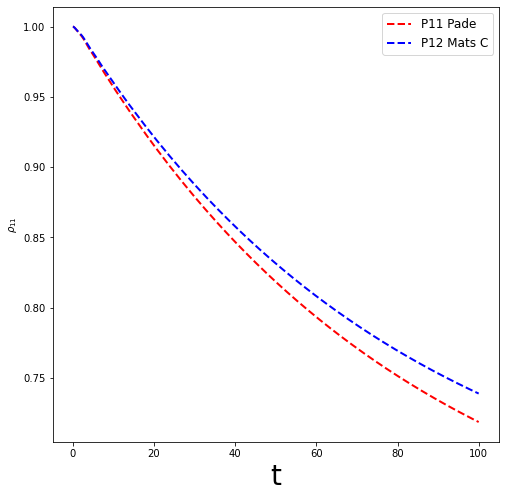

In [17]:
# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))

axes.plot(tlist, expect(out1P2.states,rho_0), 'r--', linewidth=2, label="P11 Pade ")


axes.plot(tlist, expect(out1M2.states,rho_0), 'b--', linewidth=2, label="P12 Mats C")

axes.set_ylabel(r"$\rho_{11}$")
axes.set_xlabel(r't', fontsize=28)


axes.legend(loc=0, fontsize=12)

In [18]:
#One advantage of this simple model is the current is analytically solvable, so we can check convergence of the result



def CurrFunc():
    def lamshift(w,mu):
        return (w-mu)*Gamma_w(w,mu)/(2*W)
    integrand = lambda w: ((2/(pi))*Gamma_w(w,mu_l)*Gamma_w(w,mu_r)*(f(beta*(w-mu_l))-f(beta*(w-mu_r))) /
            ((Gamma_w(w,mu_l)+Gamma_w(w,mu_r))**2 +4*(w-e1 - lamshift(w,mu_l)-lamshift(w,mu_r))**2))
    def real_func(x):
        return real(integrand(x))
    def imag_func(x):
        return imag(integrand(x))

    #in principle the bounds should be checked if parameters are changed
    a= -2
    b=2
    real_integral = quad(real_func, a, b)
    imag_integral = quad(imag_func, a, b)
    
   

    return real_integral[0] + 1.0j * imag_integral[0]
    
curr_ana = CurrFunc()
print(curr_ana)

(0.0008130726698759556+0j)


In [19]:
#we can extract the current from the auxiliary ADOs calculated in the steady state

aux_1_list_list=[]
aux1_indices_list=[]
aux_2_list_list=[]
aux2_indices_list=[]


K = Kk  


shape = H0.shape[0]
dims = H0.dims

aux_1_list, aux1_indices, idx2state = get_aux_matrices([fullssP2], 1, 4, K, Ncc, shape, dims)
aux_2_list, aux2_indices, idx2state = get_aux_matrices([fullssP2], 2, 4, K, Ncc, shape, dims)


d1 = destroy(2)   #Kk to 2*Kk
currP = -1.0j * (((sum([(d1*aux_1_list[gg][0]).tr() for gg in range(Kk,2*Kk)]))) - ((sum([(d1.dag()*aux_1_list[gg][0]).tr() for gg in range(Kk)]))))


    
   

In [20]:


aux_1_list_list=[]
aux1_indices_list=[]
aux_2_list_list=[]
aux2_indices_list=[]


K = Kk  


shape = H0.shape[0]
dims = H0.dims

aux_1_list, aux1_indices, idx2state = get_aux_matrices([fullssM2], 1, 4, K, Ncc, shape, dims)
aux_2_list, aux2_indices, idx2state = get_aux_matrices([fullssM2], 2, 4, K, Ncc, shape, dims)


d1 = destroy(2)   #Kk to 2*Kk
currM = -1.0j * (((sum([(d1*aux_1_list[gg][0]).tr() for gg in range(Kk,2*Kk)]))) - ((sum([(d1.dag()*aux_1_list[gg][0]).tr() for gg in range(Kk)]))))

In [21]:

print("Pade current", -currP)
print("Matsubara current", -currM)
print("Analytical curernt", curr_ana)

Pade current (0.0008130302805827144-0j)
Matsubara current (0.001101848531634958+1.734723475976807e-18j)
Analytical curernt (0.0008130726698759556+0j)


In [22]:

start=time.time()

currPlist = []
curranalist = []

theta_list = linspace(-4,4,100)

for theta in theta_list:
    mu_l = theta/2.
    mu_r = -theta/2.
    #Pade cut-off
    lmax = 10


    Alpha =np.zeros((2*lmax,2*lmax))
    for j in range(2*lmax):
        for k in range(2*lmax):
            Alpha[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)-1)*(2*(k+1)-1))

    eigvalsA=eigvalsh(Alpha)  

    eps = []
    for val in  eigvalsA[0:lmax]:
        #print(-2/val)
        eps.append(-2/val)

    AlphaP =np.zeros((2*lmax-1,2*lmax-1))
    for j in range(2*lmax-1):
        for k in range(2*lmax-1):
            AlphaP[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)+1)*(2*(k+1)+1))
            #AlphaP[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+2)-1)*(2*(k+2)-1))

    eigvalsAP=eigvalsh(AlphaP)    

    chi = []
    for val in  eigvalsAP[0:lmax-1]:
        #print(-2/val)
        chi.append(-2/val)


    eta_list = [0.5*lmax*(2*(lmax + 1) - 1)*( 
      np.prod([chi[k]**2 - eps[j]**2 for k in range(lmax - 1)])/
        np.prod([eps[k]**2 - eps[j]**2 +deltafun(j,k) for k in range(lmax)])) 
              for j in range(lmax)]



    kappa = [0]+eta_list

    epsilon = [0]+eps


    def f_approx(x):
        f = 0.5
        for l in range(1,lmax+1):
            f= f - 2*kappa[l]*x/(x**2+epsilon[l]**2)
        return f

    def f(x):
        kB=1.
        return 1/(exp(x)+1.)


    def C(sigma,mu):
        eta_list = []
        gamma_list  =[]


        eta_0 = 0.5*Gamma*W*f_approx(1.0j*beta*W)

        gamma_0 = W - sigma*1.0j*mu
        eta_list.append(eta_0)
        gamma_list.append(gamma_0)
        if lmax>0:
            for l in range(1,lmax+1):
                eta_list.append(-1.0j*(kappa[l]/beta)*Gamma*W**2/(-(epsilon[l]**2/beta**2)+W**2))
                gamma_list.append(epsilon[l]/beta - sigma*1.0j*mu)

        return eta_list, gamma_list



    etapL,gampL = C(1.0,mu_l)

    etamL,gammL = C(-1.0,mu_l)



    etapR,gampR = C(1.0,mu_r)

    etamR,gammR = C(-1.0,mu_r)

    #heom simu on above params (Matsubara)


    d1 = destroy(2)

    e1 = .3


    H0 = e1*d1.dag()*d1 


    Qops = [d1.dag(),d1,d1.dag(),d1]


    rho_0 = basis(2,0)*basis(2,0).dag()

    Kk=lmax+1
    Ncc = 2

    tlist = np.linspace(0,100,1000)


    eta_list = [etapR,etamR,etapL,etamL]


    gamma_list = [gampR,gammR,gampL,gammL]

    resultHEOM = FermionicHEOMSolver(H0, Qops,  eta_list, gamma_list, Ncc)
    
    rho_0 = basis(2,0)*basis(2,0).dag()
    rhossHP,fullssP=resultHEOM.steady_state() 

    


    
        #we can extract the current from the auxiliary ADOs calculated in the steady state

    aux_1_list_list=[]
    aux1_indices_list=[]
    aux_2_list_list=[]
    aux2_indices_list=[]


    K = Kk  

    shape = H0.shape[0]
    dims = H0.dims



    aux_1_list, aux1_indices, idx2state = get_aux_matrices([fullssP], 1, 4, K, Ncc, shape, dims)
    aux_2_list, aux2_indices, idx2state = get_aux_matrices([fullssP], 2, 4, K, Ncc, shape, dims)


    d1 = destroy(2)   #Kk to 2*Kk
    currP = -1.0j * (((sum([(d1*aux_1_list[gg][0]).tr() for gg in range(Kk,2*Kk)]))) - ((sum([(d1.dag()*aux_1_list[gg][0]).tr() for gg in range(Kk)]))))


    curr_ana = CurrFunc()
    
    currPlist.append(currP)
    curranalist.append(curr_ana)
 
end=time.time()

print("run time", end-start)

run time 306.5541875362396


In [23]:
matplotlib.rcParams['figure.figsize'] = (7, 5)
matplotlib.rcParams['axes.titlesize'] = 25
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['xtick.labelsize'] = 28
matplotlib.rcParams['ytick.labelsize'] = 28
matplotlib.rcParams['legend.fontsize'] = 28
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['lines.markersize'] = 5
matplotlib.rcParams['font.family'] = 'STIXgeneral' 
matplotlib.rcParams['mathtext.fontset'] =  'stix'
matplotlib.rcParams["font.serif"] = "STIX"
matplotlib.rcParams['text.usetex'] = False

/home/neill/anaconda3/envs/bofin_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/neill/anaconda3/envs/bofin_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


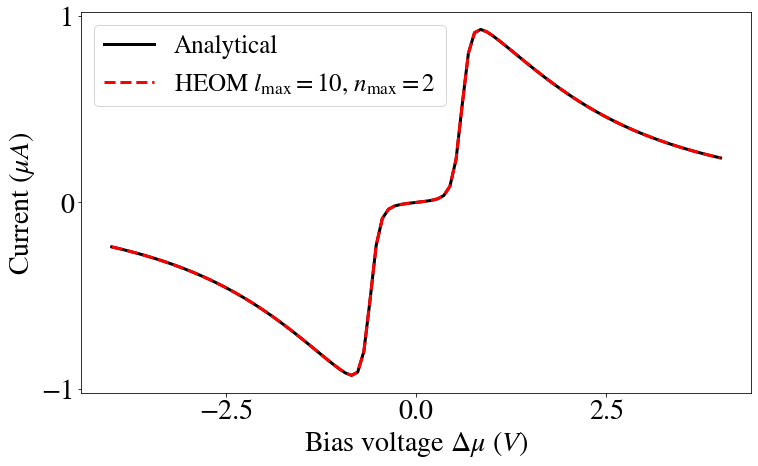

In [24]:
fig, ax1 = plt.subplots(figsize=(12,7))

ax1.plot(theta_list,2.434e-4*1e6*array(curranalist), color="black", linewidth=3, label= r"Analytical")
ax1.plot(theta_list,-2.434e-4*1e6*array(currPlist), 'r--', linewidth=3, label= r"HEOM $l_{\mathrm{max}}=10$, $n_{\mathrm{max}}=2$")


ax1.locator_params(axis='y', nbins=4)
ax1.locator_params(axis='x', nbins=4)

axes.set_xticks([-2.5,0.,2.5])
axes.set_xticklabels([-2.5,0,2.5]) 
ax1.set_xlabel(r"Bias voltage $\Delta \mu$ ($V$)",fontsize=28)
ax1.set_ylabel(r"Current ($\mu A$)",fontsize=28)
ax1.legend(fontsize=25)

#fig.savefig("figImpurity.pdf")

In [ ]:

#We can also generate the above data using the MKL solver in the steady-state method
#This tends to be quicker on very large examples.  Here it converges to the correct result, but can
#sometimes fail to converge, or give incorrect results.

currPlist = []
curranalist = []

theta_list = linspace(-4,4,100)

start = time.time()

for theta in theta_list:
    mu_l = theta/2.
    mu_r = -theta/2.
    #Pade cut-off
    lmax = 10


    Alpha =np.zeros((2*lmax,2*lmax))
    for j in range(2*lmax):
        for k in range(2*lmax):
            Alpha[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)-1)*(2*(k+1)-1))

    eigvalsA=eigvalsh(Alpha)  

    eps = []
    for val in  eigvalsA[0:lmax]:
        #print(-2/val)
        eps.append(-2/val)

    AlphaP =np.zeros((2*lmax-1,2*lmax-1))
    for j in range(2*lmax-1):
        for k in range(2*lmax-1):
            AlphaP[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)+1)*(2*(k+1)+1))
            #AlphaP[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+2)-1)*(2*(k+2)-1))

    eigvalsAP=eigvalsh(AlphaP)    

    chi = []
    for val in  eigvalsAP[0:lmax-1]:
        #print(-2/val)
        chi.append(-2/val)


    eta_list = [0.5*lmax*(2*(lmax + 1) - 1)*( 
      np.prod([chi[k]**2 - eps[j]**2 for k in range(lmax - 1)])/
        np.prod([eps[k]**2 - eps[j]**2 +deltafun(j,k) for k in range(lmax)])) 
              for j in range(lmax)]



    kappa = [0]+eta_list

    epsilon = [0]+eps


    def f_approx(x):
        f = 0.5
        for l in range(1,lmax+1):
            f= f - 2*kappa[l]*x/(x**2+epsilon[l]**2)
        return f

    def f(x):
        kB=1.
        return 1/(exp(x)+1.)


    def C(sigma,mu):
        eta_list = []
        gamma_list  =[]


        eta_0 = 0.5*Gamma*W*f_approx(1.0j*beta*W)

        gamma_0 = W - sigma*1.0j*mu
        eta_list.append(eta_0)
        gamma_list.append(gamma_0)
        if lmax>0:
            for l in range(1,lmax+1):
                eta_list.append(-1.0j*(kappa[l]/beta)*Gamma*W**2/(-(epsilon[l]**2/beta**2)+W**2))
                gamma_list.append(epsilon[l]/beta - sigma*1.0j*mu)

        return eta_list, gamma_list



    etapL,gampL = C(1.0,mu_l)

    etamL,gammL = C(-1.0,mu_l)



    etapR,gampR = C(1.0,mu_r)

    etamR,gammR = C(-1.0,mu_r)

    #heom simu on above params (Matsubara)


    d1 = destroy(2)

    e1 = .3


    H0 = e1*d1.dag()*d1 


    Qops = [d1.dag(),d1,d1.dag(),d1]


    rho_0 = basis(2,0)*basis(2,0).dag()

    Kk=lmax+1
    Ncc = 2

    tlist = np.linspace(0,100,1000)


    eta_list = [etapR,etamR,etapL,etamL]


    gamma_list = [gampR,gammR,gampL,gammL]

    resultHEOM = FermionicHEOMSolver(H0, Qops,  eta_list, gamma_list, Ncc)
    
    rho_0 = basis(2,0)*basis(2,0).dag()
    rhossHP,fullssP=resultHEOM.steady_state(use_mkl=True) 

    


    
        #we can extract the current from the auxiliary ADOs calculated in the steady state

    aux_1_list_list=[]
    aux1_indices_list=[]
    aux_2_list_list=[]
    aux2_indices_list=[]


    K = Kk  

    shape = H0.shape[0]
    dims = H0.dims



    aux_1_list, aux1_indices, idx2state = get_aux_matrices([fullssP], 1, 4, K, Ncc, shape, dims)
    aux_2_list, aux2_indices, idx2state = get_aux_matrices([fullssP], 2, 4, K, Ncc, shape, dims)


    d1 = destroy(2)   #Kk to 2*Kk
    currP = -1.0j * (((sum([(d1*aux_1_list[gg][0]).tr() for gg in range(Kk,2*Kk)]))) - ((sum([(d1.dag()*aux_1_list[gg][0]).tr() for gg in range(Kk)]))))


    curr_ana = CurrFunc()
    
    currPlist.append(currP)
    curranalist.append(curr_ana)
 
end=time.time()

print("run time", end-start)

Using Intel mkl solver
Solver Initialization
---------------------
Input matrix type:  Complex Non-symmetric
Input matrix shape: (3964, 3964)
Input matrix NNZ:   19408

Analysis and Factorization Stage
--------------------------------
Factorization time:        0.0368
Factorization memory (Mb): 2.3789
NNZ in LU factors:         26192

Solution Stage
--------------
Solution time:                   0.0071
Solution memory (Mb):            0.9434
Number of iterative refinements: 4
Total memory (Mb):               3.3223

Using Intel mkl solver
Solver Initialization
---------------------
Input matrix type:  Complex Non-symmetric
Input matrix shape: (3964, 3964)
Input matrix NNZ:   19408

Analysis and Factorization Stage
--------------------------------
Factorization time:        0.0043
Factorization memory (Mb): 2.3789
NNZ in LU factors:         26192

Solution Stage
--------------
Solution time:                   0.0007
Solution memory (Mb):            0.9277
Number of iterative refinement

Using Intel mkl solver
Solver Initialization
---------------------
Input matrix type:  Complex Non-symmetric
Input matrix shape: (3964, 3964)
Input matrix NNZ:   19408

Analysis and Factorization Stage
--------------------------------
Factorization time:        0.0121
Factorization memory (Mb): 2.3779
NNZ in LU factors:         26186

Solution Stage
--------------
Solution time:                   0.0008
Solution memory (Mb):            0.9277
Number of iterative refinements: 4
Total memory (Mb):               3.3057

Using Intel mkl solver
Solver Initialization
---------------------
Input matrix type:  Complex Non-symmetric
Input matrix shape: (3964, 3964)
Input matrix NNZ:   19408

Analysis and Factorization Stage
--------------------------------
Factorization time:        0.0041
Factorization memory (Mb): 2.3789
NNZ in LU factors:         26192

Solution Stage
--------------
Solution time:                   0.0006
Solution memory (Mb):            0.9268
Number of iterative refinement

Using Intel mkl solver
Solver Initialization
---------------------
Input matrix type:  Complex Non-symmetric
Input matrix shape: (3964, 3964)
Input matrix NNZ:   19408

Analysis and Factorization Stage
--------------------------------
Factorization time:        0.0044
Factorization memory (Mb): 2.3799
NNZ in LU factors:         26186

Solution Stage
--------------
Solution time:                   0.0009
Solution memory (Mb):            0.9268
Number of iterative refinements: 6
Total memory (Mb):               3.3066

Using Intel mkl solver
Solver Initialization
---------------------
Input matrix type:  Complex Non-symmetric
Input matrix shape: (3964, 3964)
Input matrix NNZ:   19408

Analysis and Factorization Stage
--------------------------------
Factorization time:        0.0038
Factorization memory (Mb): 2.3789
NNZ in LU factors:         26192

Solution Stage
--------------
Solution time:                   0.0009
Solution memory (Mb):            0.9277
Number of iterative refinement

Using Intel mkl solver
Solver Initialization
---------------------
Input matrix type:  Complex Non-symmetric
Input matrix shape: (3964, 3964)
Input matrix NNZ:   19408

Analysis and Factorization Stage
--------------------------------
Factorization time:        0.004
Factorization memory (Mb): 2.3779
NNZ in LU factors:         26192

Solution Stage
--------------
Solution time:                   0.0006
Solution memory (Mb):            0.9268
Number of iterative refinements: 4
Total memory (Mb):               3.3047

Using Intel mkl solver
Solver Initialization
---------------------
Input matrix type:  Complex Non-symmetric
Input matrix shape: (3964, 3964)
Input matrix NNZ:   19408

Analysis and Factorization Stage
--------------------------------
Factorization time:        0.0042
Factorization memory (Mb): 2.3779
NNZ in LU factors:         26192

Solution Stage
--------------
Solution time:                   0.0008
Solution memory (Mb):            0.9268
Number of iterative refinements

Using Intel mkl solver
Solver Initialization
---------------------
Input matrix type:  Complex Non-symmetric
Input matrix shape: (3964, 3964)
Input matrix NNZ:   19408

Analysis and Factorization Stage
--------------------------------
Factorization time:        0.0047
Factorization memory (Mb): 2.3779
NNZ in LU factors:         26192

Solution Stage
--------------
Solution time:                   0.0012
Solution memory (Mb):            0.9268
Number of iterative refinements: 6
Total memory (Mb):               3.3047

Using Intel mkl solver
Solver Initialization
---------------------
Input matrix type:  Complex Non-symmetric
Input matrix shape: (3964, 3964)
Input matrix NNZ:   19408

Analysis and Factorization Stage
--------------------------------
Factorization time:        0.0044
Factorization memory (Mb): 2.3779
NNZ in LU factors:         26192

Solution Stage
--------------
Solution time:                   0.0011
Solution memory (Mb):            0.9268
Number of iterative refinement

Using Intel mkl solver
Solver Initialization
---------------------
Input matrix type:  Complex Non-symmetric
Input matrix shape: (3964, 3964)
Input matrix NNZ:   19408

Analysis and Factorization Stage
--------------------------------
Factorization time:        0.0039
Factorization memory (Mb): 2.3779
NNZ in LU factors:         26192

Solution Stage
--------------
Solution time:                   0.001
Solution memory (Mb):            0.9268
Number of iterative refinements: 5
Total memory (Mb):               3.3047

Using Intel mkl solver
Solver Initialization
---------------------
Input matrix type:  Complex Non-symmetric
Input matrix shape: (3964, 3964)
Input matrix NNZ:   19408

Analysis and Factorization Stage
--------------------------------
Factorization time:        0.0049
Factorization memory (Mb): 2.3789
NNZ in LU factors:         26192

Solution Stage
--------------
Solution time:                   0.0014
Solution memory (Mb):            0.9434
Number of iterative refinements

/home/neill/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


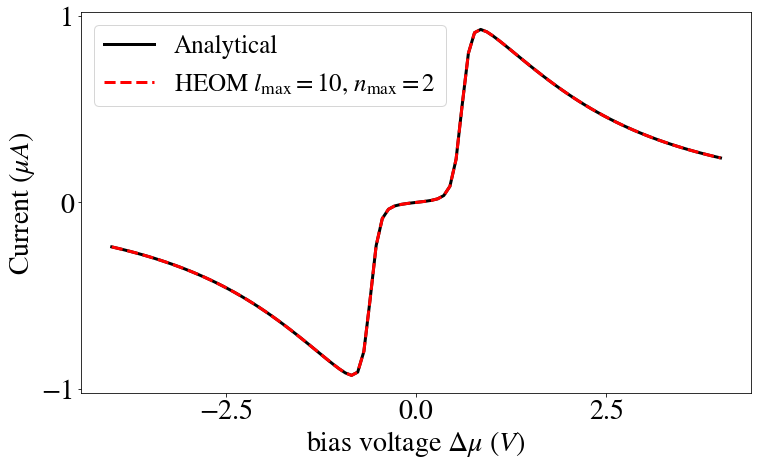

In [33]:
fig, ax1 = plt.subplots(figsize=(12,7))

ax1.plot(theta_list,2.434e-4*1e6*array(curranalist), color="black", linewidth=3, label= r"Analytical")
ax1.plot(theta_list,-2.434e-4*1e6*array(currPlist), 'r--', linewidth=3, label= r"HEOM $l_{\mathrm{max}}=10$, $n_{\mathrm{max}}=2$")


ax1.locator_params(axis='y', nbins=4)
ax1.locator_params(axis='x', nbins=4)

axes.set_xticks([-2.5,0.,2.5])
axes.set_xticklabels([-2.5,0,2.5]) 
ax1.set_xlabel(r"bias voltage $\Delta \mu$ ($V$)",fontsize=28)
ax1.set_ylabel(r"Current ($\mu A$)",fontsize=28)
ax1.legend(fontsize=25)

